In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Jan 19 03:20:43 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   48C    P0    71W / 300W |   8433MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.multi_randn_prior import Prior
from model.latent.multi_lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.n_latents = 32
hp.n_prior_embeddings = 256
hp.activation = F.sigmoid
hp.init_log_sigma = -4
hp.const_sigma = True

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 4.0
latent 4.016117095947266
latent.multi_latents_encoder 2.015625
latent.multi_latents_decoder 2.00048828125
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.18-10/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 12
-rw-rw-r-- 1 scpark scpark  40  1월 19 03:20 events.out.tfevents.1705601999.GPUSVR11
-rw-rw-r-- 1 scpark scpark 130  1월 19 03:18 events.out.tfevents.1705601784.GPUSVR11
-rw-rw-r-- 1 scpark scpark  40  1월 19 03:16 events.out.tfevents.1705601635.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.0183], device='cuda:0')


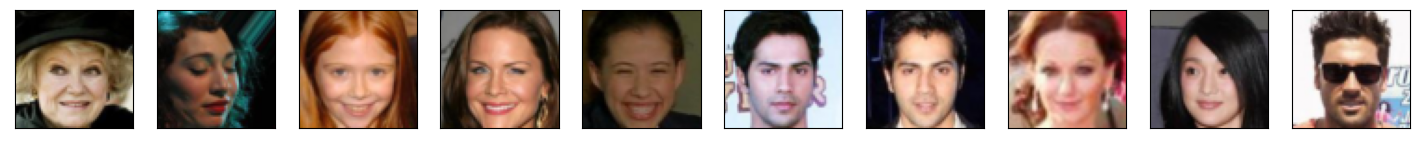

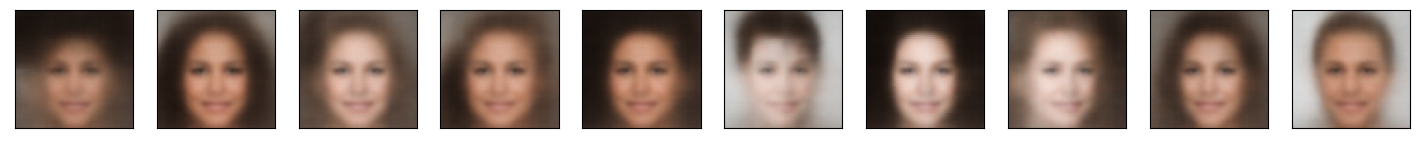

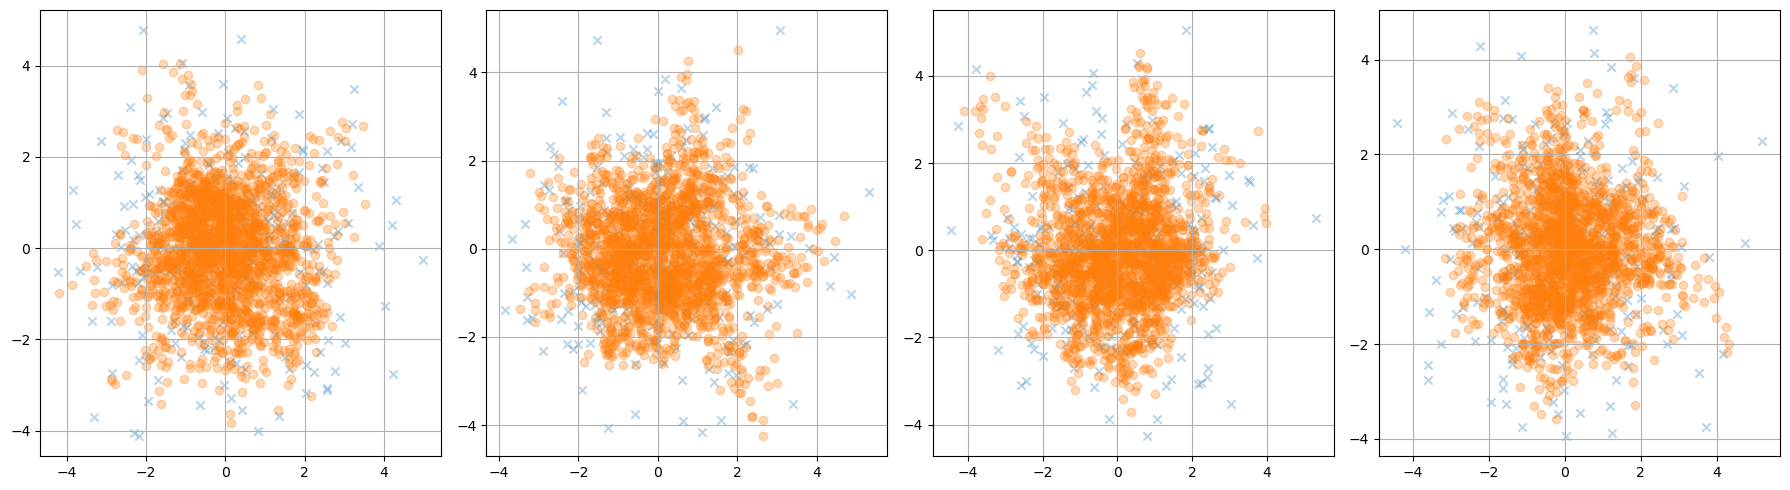

1001
lse_loss 125716.40625
recon_loss 0.03461559861898422
1002
lse_loss 125112.1875
recon_loss 0.03311309963464737
1003
lse_loss 123577.8125
recon_loss 0.03477882593870163
1004
lse_loss 124579.3671875
recon_loss 0.03342633694410324
1005
lse_loss 126469.59375
recon_loss 0.03460652753710747
1006
lse_loss 125726.53125
recon_loss 0.03558093309402466
1007
lse_loss 124704.03125
recon_loss 0.035777755081653595
1008
lse_loss 123405.734375
recon_loss 0.03466218337416649
1009
lse_loss 123762.6796875
recon_loss 0.03440283238887787
1010
lse_loss 126232.296875
recon_loss 0.036199901252985
1011
lse_loss 123336.515625
recon_loss 0.03579298406839371
1012
lse_loss 124874.796875
recon_loss 0.03496405482292175
1013
lse_loss 123433.578125
recon_loss 0.033252470195293427
1014
lse_loss 125593.609375
recon_loss 0.03536435589194298
1015
lse_loss 123817.859375
recon_loss 0.03435111045837402
1016
lse_loss 124221.453125
recon_loss 0.03231237083673477
1017
lse_loss 126107.484375
recon_loss 0.035110678523778915
10

1141
lse_loss 120560.2734375
recon_loss 0.0358286127448082
1142
lse_loss 120419.546875
recon_loss 0.034309785813093185
1143
lse_loss 121220.3359375
recon_loss 0.03407232463359833
1144
lse_loss 120786.2578125
recon_loss 0.0335223488509655
1145
lse_loss 120420.0078125
recon_loss 0.034996114671230316
1146
lse_loss 120278.984375
recon_loss 0.0349620059132576
1147
lse_loss 120119.15625
recon_loss 0.033092472702264786
1148
lse_loss 118842.0
recon_loss 0.03443218767642975
1149
lse_loss 123254.2734375
recon_loss 0.03463941439986229
1150
lse_loss 121805.3984375
recon_loss 0.03304288163781166
1151
lse_loss 121624.78125
recon_loss 0.03416481614112854
1152
lse_loss 120311.53125
recon_loss 0.03654767572879791
1153
lse_loss 121467.1171875
recon_loss 0.03397321328520775
1154
lse_loss 121242.09375
recon_loss 0.03639970347285271
1155
lse_loss 120512.0078125
recon_loss 0.03537717089056969
1156
lse_loss 121194.75
recon_loss 0.036982737481594086
1157
lse_loss 121900.375
recon_loss 0.03490513563156128
1158

1281
lse_loss 117942.4765625
recon_loss 0.0346280038356781
1282
lse_loss 118308.71875
recon_loss 0.03305165469646454
1283
lse_loss 121130.5
recon_loss 0.03685612231492996
1284
lse_loss 119555.796875
recon_loss 0.03510016202926636
1285
lse_loss 120011.3671875
recon_loss 0.03178038448095322
1286
lse_loss 121283.046875
recon_loss 0.03404952585697174
1287
lse_loss 121551.5
recon_loss 0.03345063328742981
1288
lse_loss 118868.359375
recon_loss 0.03646930307149887
1289
lse_loss 122094.3984375
recon_loss 0.035112738609313965
1290
lse_loss 118802.65625
recon_loss 0.03447994217276573
1291
lse_loss 118726.6796875
recon_loss 0.03520306199789047
1292
lse_loss 118425.5
recon_loss 0.03483869880437851
1293
lse_loss 121570.6875
recon_loss 0.036557387560606
1294
lse_loss 120602.0078125
recon_loss 0.036428891122341156
1295
lse_loss 118610.15625
recon_loss 0.03503137081861496
1296
lse_loss 118802.046875
recon_loss 0.0352313332259655
1297
lse_loss 119273.484375
recon_loss 0.035161953419446945
1298
lse_loss

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            print(torch.exp(model.latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            from sklearn.decomposition import PCA
            plt.figure(figsize=[18, 5])
            for i in range(4):

                pca = PCA(n_components=2)
                e = model.prior.prior[i].data.cpu().numpy()
                pca.fit(e)
                e_pca = pca.transform(e)
                z = data['z_multi'][i]
                z_pca = pca.transform(z.data.cpu().numpy())

                plt.subplot(1, 4, i+1)
                plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=0.3)
                plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.3)
                plt.grid()
                plt.tight_layout()
            plt.show()    
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')